In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPVisionModel
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

device = "cuda" if torch.cuda.is_available() else "cpu"

CONFIG = {
    "batch_size": 32,
    "epochs": 5,
    "lr": 1e-4,
    "margin": 1.0,  # For triplet loss
    "embedding_dim": 128
}


In [26]:
class TrainImageDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id, label = row['file_id'], row['class']
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image)
        return image_tensor, label, file_id

class TripletDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_indices = self._create_label_mapping()

    def _create_label_mapping(self):
        mapping = {}
        for idx, label in enumerate(self.df['class']):
            mapping.setdefault(label, []).append(idx)
        return mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_row = self.df.iloc[idx]
        anchor_img, anchor_label = self._load_image(anchor_row)

        positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_row = self.df.iloc[positive_idx]
        positive_img, _ = self._load_image(positive_row)

        negative_label = np.random.choice(
            [lbl for lbl in self.label_to_indices if lbl != anchor_label]
        )
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_row = self.df.iloc[negative_idx]
        negative_img, _ = self._load_image(negative_row)

        return anchor_img, positive_img, negative_img

    def _load_image(self, row):
        img_path = os.path.join(self.img_dir, f"{row['file_id']}.jpg")
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), row['class']


In [3]:
class MetricLearningModel(nn.Module):
    def __init__(self, backbone_name="openai/clip-vit-base-patch32", embedding_dim=128):
        super().__init__()
        self.backbone = CLIPVisionModel.from_pretrained(backbone_name)
        vision_hidden_dim = self.backbone.config.hidden_size

        self.embedding_layer = nn.Sequential(
            nn.Linear(vision_hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim),
        )

    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = outputs.pooler_output  # [B, vision_hidden_dim]
        embeddings = self.embedding_layer(features)  # [B, embedding_dim]

        # Normalize embeddings for metric learning
        embeddings = F.normalize(embeddings, p=2, dim=-1)
        return embeddings


In [4]:
def train_metric_learning(model, loader, optimizer, margin, device):
    model.train()
    total_loss = 0.0
    criterion = nn.TripletMarginLoss(margin=margin)

    for anchor, positive, negative in tqdm(loader, desc="Training"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Compute embeddings
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute triplet loss
        loss = criterion(anchor_emb, positive_emb, negative_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [28]:
@torch.no_grad()
def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    file_ids = []

    for images, lbls, ids in tqdm(loader, desc="Extracting Embeddings"):
        images = images.to(device)
        emb = model(images)  # Ensure this outputs [batch_size, embedding_dim]
        
        # Check if the embeddings are 2D; reshape if necessary
        if len(emb.shape) > 2:
            emb = emb.view(emb.size(0), -1)  # Flatten spatial dimensions
        
        embeddings.append(emb.cpu())
        labels.extend(lbls)
        file_ids.extend(ids)  # Collect file IDs

    # Concatenate all embeddings into a 2D tensor
    return torch.cat(embeddings, dim=0), labels, file_ids


import numpy as np
from sklearn.metrics import average_precision_score

def calculate_map_at_5(test_embeddings, train_embeddings, test_labels, train_labels):
    # Compute pairwise cosine similarities
    similarities = torch.mm(test_embeddings, train_embeddings.t())  # [N_test, N_train]
    
    # Get top-5 indices for each test embedding
    top5_indices = torch.topk(similarities, k=5, dim=1).indices  # [N_test, 5]

    ap_scores = []
    for i, true_label in enumerate(test_labels):
        # Extract top-5 predicted labels
        top5_labels = [train_labels[j] for j in top5_indices[i].tolist()]
        
        # Create binary relevance vector (1 if label matches, 0 otherwise)
        y_true = np.array([1 if lbl == true_label else 0 for lbl in top5_labels])
        
        # Create scores (cosine similarities of top-5 predictions)
        y_scores = similarities[i, top5_indices[i]].cpu().numpy()
        
        # Only calculate average precision if y_true has at least one positive class
        if y_true.sum() > 0:
            ap = average_precision_score(y_true, y_scores)
            ap_scores.append(ap)
        else:
            ap_scores.append(0)  # No positive class, AP is 0

    return np.mean(ap_scores) if ap_scores else 0.0


In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5659, 0.5438, 0.5094], std=[0.3031, 0.3019, 0.3209]),
])

# Dataset
train_df = pd.read_csv("/kaggle/input/ucu-computer-vision-2024/train.csv")
test_df = pd.read_csv("/kaggle/input/ucu-computer-vision-2024/test.csv")
train_img_dir = "/kaggle/input/ucu-computer-vision-2024/train"
test_img_dir = "/kaggle/input/ucu-computer-vision-2024/test"

triplet_dataset = TripletDataset(train_df, train_img_dir, transform)
triplet_loader = DataLoader(triplet_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

# Model and optimizer
model = MetricLearningModel(embedding_dim=CONFIG["embedding_dim"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])

# Training
for epoch in range(1, CONFIG["epochs"] + 1):
    loss = train_metric_learning(model, triplet_loader, optimizer, CONFIG["margin"], device)
    print(f"Epoch {epoch} - Loss: {loss:.4f}")


Training: 100%|██████████| 113/113 [02:29<00:00,  1.32s/it]


Epoch 1 - Loss: 0.4303


Training: 100%|██████████| 113/113 [02:08<00:00,  1.14s/it]


Epoch 2 - Loss: 0.4035


Training: 100%|██████████| 113/113 [02:09<00:00,  1.15s/it]


Epoch 3 - Loss: 0.3676


Training: 100%|██████████| 113/113 [02:09<00:00,  1.14s/it]


Epoch 4 - Loss: 0.3429


Training: 100%|██████████| 113/113 [02:09<00:00,  1.15s/it]


Epoch 5 - Loss: 0.3502


Extracting Embeddings:   0%|          | 0/113 [00:00<?, ?it/s]


NameError: name 'batch_size' is not defined

In [32]:
# Evaluation
batch_size = 512

test_dataset = TrainImageDataset(test_df, test_img_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

train_dataset = TrainImageDataset(train_df, train_img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

train_embeddings, train_labels, train_file_ids = extract_embeddings(model, train_loader)
test_embeddings, test_labels, test_file_ids = extract_embeddings(model, test_loader)

map_at_5 = calculate_map_at_5(test_embeddings, train_embeddings, test_labels, train_labels)
print(f"mAP@5: {map_at_5:.4f}")

Extracting Embeddings: 100%|██████████| 410/410 [01:52<00:00,  3.65it/s]


mAP@5: 0.0000


In [33]:
import torch.nn.functional as F

def classify_distractors_with_cosine(
    test_emb, train_emb, contamination_rate=0.3
):
    max_similarities = []
    for t in test_emb:
        sims = F.cosine_similarity(t.unsqueeze(0), train_emb, dim=1)
        max_similarities.append(sims.max().item())
    max_sims = torch.tensor(max_similarities)

    # Sort descending
    sorted_sims, _ = torch.sort(max_sims, descending=True)
    idx = int(len(sorted_sims)*(1 - contamination_rate))
    threshold = sorted_sims[idx].item()

    # Distractors = below threshold
    distractor_mask = max_sims < threshold
    return distractor_mask, threshold

distractor_mask, threshold = classify_distractors_with_cosine(
    test_embeddings, train_embeddings, contamination_rate=0.3
)
print("Threshold:", threshold)
print("Distractors found:", distractor_mask.sum().item(), "out of", len(test_embeddings))


Threshold: 0.9878682494163513
Distractors found: 3934 out of 13115


In [34]:
distractor_mask_a = np.array(distractor_mask).astype(int)
print(f"""Distractor filtering results: 
threshold is: {threshold:.2f} 
for contamination rate: {len(test_df.loc[distractor_mask_a == 1]) / len(test_df):.2f}""")

Distractor filtering results: 
threshold is: 0.99 
for contamination rate: 0.30


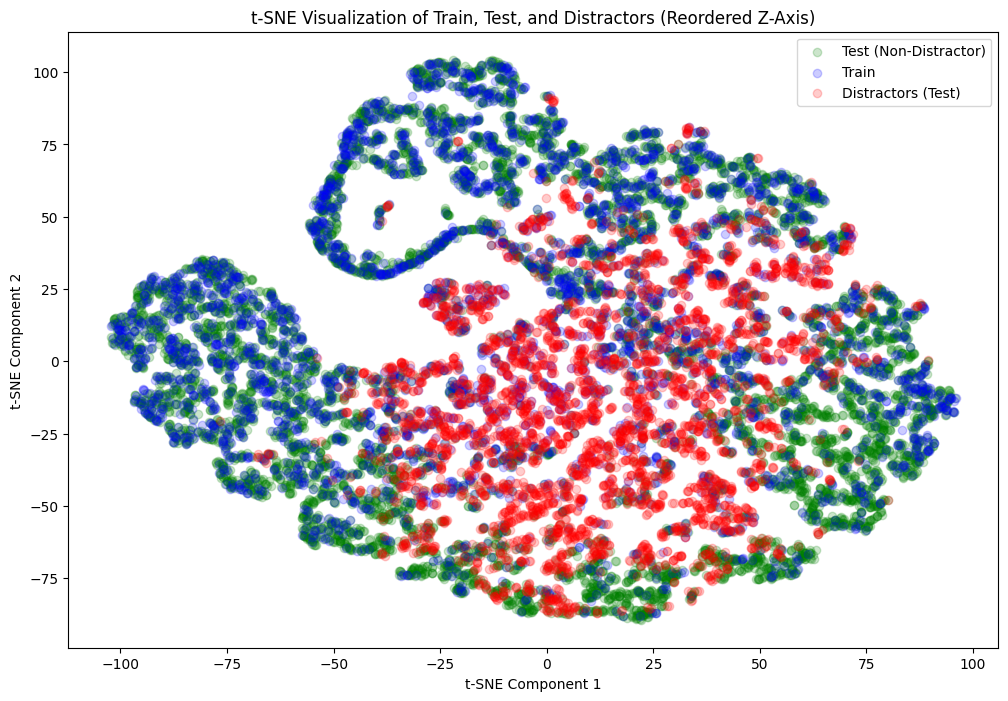

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Step 3: Combine embeddings
train_labels = np.zeros(len(train_embeddings))
test_labels = np.ones(len(test_embeddings))

# Combine embeddings and labels
all_embeddings = torch.cat([train_embeddings, test_embeddings], dim=0).cpu().numpy()
all_labels = np.concatenate([train_labels, test_labels])

# Ensure distractor mask aligns with test embeddings
distractor_test_labels = np.concatenate([np.zeros(len(train_labels)), distractor_mask_a])

# Step 4: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Step 5: Visualize
plt.figure(figsize=(12, 8))

# Plot test embeddings in the background
test_indices = np.where((all_labels == 1) & (distractor_test_labels == 0))
plt.scatter(tsne_results[test_indices, 0], tsne_results[test_indices, 1], 
            c="green", label="Test (Non-Distractor)", alpha=0.2, zorder=1)

# Plot train embeddings in the middle
train_indices = np.where(all_labels == 0)
plt.scatter(tsne_results[train_indices, 0], tsne_results[train_indices, 1], 
            c="blue", label="Train", alpha=0.2, zorder=2)

# Plot distractors on top
distractor_test_indices = np.where((all_labels == 1) & (distractor_test_labels == 1))
plt.scatter(tsne_results[distractor_test_indices, 0], tsne_results[distractor_test_indices, 1], 
            c="red", label="Distractors (Test)", alpha=0.2, zorder=3)

plt.title("t-SNE Visualization of Train, Test, and Distractors (Reordered Z-Axis)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

In [36]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np

# Step 4: Predict top-5 classes for non-distractors (Cosine Similarity) in batches
def predict_top_5_with_distractors_batched(image_embeddings, class_embeddings, distractor_indices, test_file_ids, class_indices, batch_size=64):
    predictions = {}

    # Ensure distractor_indices is processed correctly (flattened array)
    distractor_set = set(distractor_indices[0])  # Extract the array from the tuple
    distractor_mask = np.zeros(len(test_file_ids), dtype=bool)
    distractor_mask[list(distractor_set)] = True  # Create boolean mask for distractors

    # Ensure embeddings are on the same device
    device = image_embeddings.device
    class_embeddings = class_embeddings.to(device)

    # Process in batches
    for batch_start in tqdm(range(0, len(test_file_ids), batch_size), desc="Processing Batches"):
        batch_end = min(batch_start + batch_size, len(test_file_ids))
        batch_indices = range(batch_start, batch_end)

        # Extract batch data
        batch_embeddings = image_embeddings[batch_start:batch_end]
        batch_distractor_mask = distractor_mask[batch_start:batch_end]
        batch_file_ids = test_file_ids[batch_start:batch_end]

        # Compute cosine similarity for the batch
        similarities = F.cosine_similarity(batch_embeddings.unsqueeze(1), class_embeddings.unsqueeze(0), dim=2)

        # Generate predictions for the batch
        for i, file_id in enumerate(batch_file_ids):
            # Get top-5 classes based on similarity
            top5_indices = torch.topk(similarities[i], 5).indices.tolist()  # Top 5 from class embeddings
            top5_classes = [class_indices[j] for j in top5_indices]

            if batch_distractor_mask[i]:  # If distractor, prepend -1
                predictions[file_id] = [-1] + top5_classes[:4]
            else:  # Otherwise, just top-5 predictions
                predictions[file_id] = top5_classes

    return predictions

# Generate a mapping from class embeddings to their corresponding classes
class_indices = train_df['class'].values

# Step 5: Generate predictions using batch processing
batch_size = 512  # Adjust batch size to your memory constraints
distractor_indices = np.where(distractor_mask_a == 1)  # Ensure distractor_mask_a exists
test_predictions = predict_top_5_with_distractors_batched(
    test_embeddings,
    train_embeddings,
    distractor_indices,
    test_file_ids,
    class_indices,
    batch_size=batch_size
)

# Step 6: Save predictions for Kaggle submission
submission = []
for file_id, preds in test_predictions.items():
    submission.append({"file_id": file_id, "class": " ".join(map(str, preds))})

submission_df = pd.DataFrame(submission)

submission_file_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Kaggle submission file saved to: {submission_file_path}")


Processing Batches: 100%|██████████| 26/26 [00:38<00:00,  1.46s/it]

Kaggle submission file saved to: /kaggle/working/submission.csv
